# Solar Power Performance Analysis using Data Science

## Project Overview
This project analyzes and monitors the performance of a solar power plant using real-world
data collected from multiple inverter clusters and a weather station.

The main objectives are:
- To preprocess and merge inverter and weather data
- To explore solar power generation patterns using EDA
- To build machine learning models for:
  - Power output prediction (Regression)
  - Cluster performance classification (High / Low)
- To support decision-making via analytical insights and dashboards



## 1. Environment Setup

This notebook was originally developed using Google Colab.
The following step mounts Google Drive to access the raw dataset.


In [1]:
# Mount Google Drive (for Colab environment)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 2. Dataset Directory Structure

The dataset is organized by days (June 2024), where each folder represents one day.
Each daily folder contains:
- Inverter Data.xls
- Weather Condition.xls

We first inspect the available daily folders.





In [2]:
import os

# Base directory containing all daily folders
base_path = "/content/drive/MyDrive/2407_Weather Station (Jun24)"

# List available day folders
days = sorted(os.listdir(base_path))

# Preview first few folders
print(days[:5])


['01062024', '02062024', '03062024', '04062024', '05062024']


## 3. Inspecting Inverter Data Structure

Each inverter file contains multiple sheets.
Each sheet represents a solar cluster (CLUSTER01 to CLUSTER13).

We inspect one example day to understand the sheet structure.


In [3]:
import pandas as pd

# Select a sample day
day_folder = os.path.join(base_path, "01062024")
inverter_path = os.path.join(day_folder, "Inverter Data.xls")

# Load Excel file and inspect sheet names
xls = pd.ExcelFile(inverter_path)
print(xls.sheet_names)


['Sheet0', 'CLUSTER01', 'CLUSTER02', 'CLUSTER03', 'CLUSTER04', 'CLUSTER05', 'CLUSTER06', 'CLUSTER07', 'CLUSTER08', 'CLUSTER09', 'CLUSTER10', 'CLUSTER11', 'CLUSTER12', 'CLUSTER13']


## 4. Extracting Inverter Power Data

For each cluster:
- The first column represents the timestamp
- Remaining columns represent inverter power readings
- We sum all inverter values to obtain total power per cluster


In [4]:
cluster_data = []

for sheet in xls.sheet_names:
    if not sheet.startswith("CLUSTER"):
        continue  # Skip non-cluster sheets

    df = xls.parse(sheet)

    # Extract timestamp column
    df["timestamp"] = df.iloc[:, 0]
    df = df.drop(df.columns[0], axis=1)

    # Convert inverter readings to numeric and sum power
    df_numeric = df.apply(pd.to_numeric, errors='coerce')
    df["total_power_kw"] = df_numeric.sum(axis=1)

    # Add cluster label
    df["cluster"] = sheet

    cluster_data.append(df[["timestamp", "cluster", "total_power_kw"]])

# Combine all clusters into one DataFrame
inverter_df = pd.concat(cluster_data, ignore_index=True)

# Preview result
inverter_df.head()


,timestamp,cluster,total_power_kw
0,NaN,CLUSTER01,0.00
1,NaN,CLUSTER01,0.00
2,07:00:00,CLUSTER01,3.98
3,07:05:00,CLUSTER01,4.38
4,07:10:00,CLUSTER01,46.85


## 5. Inspecting Weather Data Structure

The weather file contains solar irradiance readings.
Before extraction, we inspect the available sheets and raw structure
to identify the correct sheet, columns, and header rows.


In [5]:
# Path to weather data for a sample day
weather_path = os.path.join(day_folder, "Weather Condition.xls")

# Inspect available sheets
xls_weather = pd.ExcelFile(weather_path)
print(xls_weather.sheet_names)


['Sheet0', 'sheet1']


## 6. Extracting Solar Irradiance Data

Based on inspection:
- Sheet name: `sheet1`
- Column A (index 0): timestamp
- Column O (index 14): average irradiance
- First 4 rows contain metadata and should be skipped


In [6]:
# Extract timestamp and irradiance
weather_df = pd.read_excel(
    weather_path,
    sheet_name="sheet1",
    skiprows=4,
    usecols=[0, 14],
    names=["timestamp", "irradiance"]
)

# Remove missing values
weather_df = weather_df.dropna(subset=["timestamp", "irradiance"]).reset_index(drop=True)

# Preview extracted data
weather_df.head()


,timestamp,irradiance
0,07:05:00,0.000
1,07:10:00,0.000
2,07:15:00,0.000
3,07:20:00,0.003
4,07:25:00,0.003


## 7. Merging Inverter and Weather Data (Single Day)

We now merge inverter power data with weather irradiance data
using the timestamp as the common key.


In [7]:
# Merge inverter and weather data for the selected day
merged_df = pd.merge(inverter_df, weather_df, on="timestamp", how="inner")

# Preview merged result
merged_df.head()


,timestamp,cluster,total_power_kw,irradiance
0,07:05:00,CLUSTER01,4.38,0.000
1,07:10:00,CLUSTER01,46.85,0.000
2,07:15:00,CLUSTER01,18.52,0.000
3,07:20:00,CLUSTER01,32.45,0.003
4,07:25:00,CLUSTER01,40.65,0.003


## 8. Automating Data Extraction for All Days

To scale the analysis, we define reusable functions:
- `extract_weather_data()` for irradiance
- `extract_inverter_data()` for total cluster power

These functions are applied to all daily folders (June 2024).


In [8]:
from tqdm import tqdm

def extract_weather_data(weather_path):
    """
    Extract timestamp and irradiance from weather file
    """
    try:
        df = pd.read_excel(
            weather_path,
            sheet_name="sheet1",
            skiprows=4,
            usecols=[0, 14],
            names=["timestamp", "irradiance"]
        )
        return df.dropna(subset=["timestamp", "irradiance"]).reset_index(drop=True)
    except:
        return pd.DataFrame(columns=["timestamp", "irradiance"])


def extract_inverter_data(inverter_path):
    """
    Extract total power output per cluster
    """
    try:
        xls = pd.ExcelFile(inverter_path)
        cluster_data = []

        for sheet in xls.sheet_names:
            if not sheet.startswith("CLUSTER"):
                continue

            df = xls.parse(sheet)
            df["timestamp"] = df.iloc[:, 0]
            df = df.drop(df.columns[0], axis=1)

            df_numeric = df.apply(pd.to_numeric, errors='coerce')
            df["total_power_kw"] = df_numeric.sum(axis=1)
            df["cluster"] = sheet

            cluster_data.append(df[["timestamp", "cluster", "total_power_kw"]])

        return pd.concat(cluster_data, ignore_index=True)

    except:
        return pd.DataFrame(columns=["timestamp", "cluster", "total_power_kw"])


## 9. Merging Data for the Entire Month (June 2024)

We iterate through all daily folders, merge inverter and weather data,
and combine everything into a single dataset.


In [9]:
# Generate list of all days in June 2024
days = [f"{day:02}062024" for day in range(1, 31)]

all_days_data = []

for day in tqdm(days):
    day_folder = os.path.join(base_path, day)
    inverter_path = os.path.join(day_folder, "Inverter Data.xls")
    weather_path = os.path.join(day_folder, "Weather Condition.xls")

    if not os.path.exists(inverter_path) or not os.path.exists(weather_path):
        print(f"⚠️ Missing files in {day}")
        continue

    inverter_df = extract_inverter_data(inverter_path)
    weather_df = extract_weather_data(weather_path)

    if inverter_df.empty or weather_df.empty:
        print(f"⚠️ Empty data in {day}")
        continue

    merged = pd.merge(inverter_df, weather_df, on="timestamp", how="inner")
    merged["day"] = day

    all_days_data.append(merged)

# Combine all days into one DataFrame
final_df = pd.concat(all_days_data, ignore_index=True)

print("✅ Total records:", len(final_df))
final_df.head()


 20%|██        | 6/30 [00:10<00:46,  1.94s/it]

⚠️ Missing files in 07062024
⚠️ Missing files in 08062024
⚠️ Missing files in 09062024
⚠️ Missing files in 10062024


 50%|█████     | 15/30 [00:19<00:20,  1.38s/it]

⚠️ Missing files in 16062024


 70%|███████   | 21/30 [00:29<00:14,  1.65s/it]

⚠️ Missing files in 22062024
⚠️ Missing files in 23062024


 90%|█████████ | 27/30 [00:37<00:04,  1.55s/it]

⚠️ Missing files in 28062024


100%|██████████| 30/30 [00:41<00:00,  1.38s/it]

✅ Total records: 44330


,timestamp,cluster,total_power_kw,irradiance,day
0,07:05:00,CLUSTER01,4.38,0.000,01062024
1,07:10:00,CLUSTER01,46.85,0.000,01062024
2,07:15:00,CLUSTER01,18.52,0.000,01062024
3,07:20:00,CLUSTER01,32.45,0.003,01062024
4,07:25:00,CLUSTER01,40.65,0.003,01062024


## 10. Saving the Processed Dataset

The final merged dataset will be saved and used for:
- Exploratory Data Analysis (EDA)
- Machine Learning modeling
- Dashboard visualization


In [14]:
# Save processed dataset
final_df.to_csv("/content/drive/MyDrive/solar_data_merged.csv", index=False)



## 11. Loading the Processed Dataset

We now load the final processed dataset that contains
merged inverter and weather data for the entire month.
This dataset will be used for EDA and modeling.


In [13]:
import pandas as pd

# Load processed dataset
df = pd.read_csv("/content/drive/MyDrive/solar_data_merged.csv")

# Preview dataset
df.head(10)


,timestamp,cluster,total_power_kw,irradiance,day
0,07:05:00,CLUSTER01,4.38,0.000,1062024
1,07:10:00,CLUSTER01,46.85,0.000,1062024
2,07:15:00,CLUSTER01,18.52,0.000,1062024
3,07:20:00,CLUSTER01,32.45,0.003,1062024
4,07:25:00,CLUSTER01,40.65,0.003,1062024
5,07:30:00,CLUSTER01,56.03,0.005,1062024
6,07:35:00,CLUSTER01,70.91,0.007,1062024
7,07:40:00,CLUSTER01,76.10,0.008,1062024
8,07:45:00,CLUSTER01,88.31,0.011,1062024
9,07:50:00,CLUSTER01,104.20,0.014,1062024


## 12. Dataset Overview and Sanity Checks

Before analysis, we inspect:
- Dataset shape
- Column names
- Basic statistics
This ensures the data is consistent and ready for analysis.


In [15]:
# Dataset shape
print("Dataset shape:", df.shape)

# Column names
print("Columns:", df.columns.tolist())

# Summary statistics
df.describe()


Dataset shape: (44330, 5)
Columns: ['timestamp', 'cluster', 'total_power_kw', 'irradiance', 'day']


,total_power_kw,irradiance,day
count,44330.000000,44330.000000,4.433000e+04
mean,536.288823,7.449693,1.560748e+07
std,568.330788,6.095010,9.023945e+06
min,0.000000,0.000000,1.062024e+06
25%,70.692500,0.959000,6.062024e+06
50%,311.630000,7.230500,1.606202e+07
75%,867.502500,13.189000,2.406202e+07
max,2461.390000,20.472000,3.006202e+07


## 13. Data Cleaning

To ensure meaningful analysis:
- We remove records with zero or negative irradiance
- These values correspond to night-time or invalid readings


In [16]:
# Filter out zero or negative irradiance values
df = df[df["irradiance"] > 0].reset_index(drop=True)

print("Dataset shape after filtering:", df.shape)


Dataset shape after filtering: (39364, 5)


## 14. Feature Engineering

We extract additional features to support analysis and modeling:
- `hour`: extracted from timestamp
- `efficiency`: power generated per unit irradiance


In [17]:
# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%H:%M:%S")

# Extract hour of the day
df["hour"] = df["timestamp"].dt.hour

# Calculate efficiency
df["efficiency"] = df["total_power_kw"] / df["irradiance"]

# Preview engineered features
df.head()


,timestamp,cluster,total_power_kw,irradiance,day,hour,efficiency
0,1900-01-01 07:20:00,CLUSTER01,32.45,0.003,1062024,7,10816.666667
1,1900-01-01 07:25:00,CLUSTER01,40.65,0.003,1062024,7,13550.000000
2,1900-01-01 07:30:00,CLUSTER01,56.03,0.005,1062024,7,11206.000000
3,1900-01-01 07:35:00,CLUSTER01,70.91,0.007,1062024,7,10130.000000
4,1900-01-01 07:40:00,CLUSTER01,76.10,0.008,1062024,7,9512.500000


## 15. Exploratory Data Analysis (EDA)

We begin exploratory analysis to understand:
- Relationship between irradiance and power output
- Performance differences between clusters
- Daily and hourly generation patterns


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


### 15.1 Irradiance vs Power Output

This scatter plot illustrates how solar irradiance
influences the total power generated by all clusters.


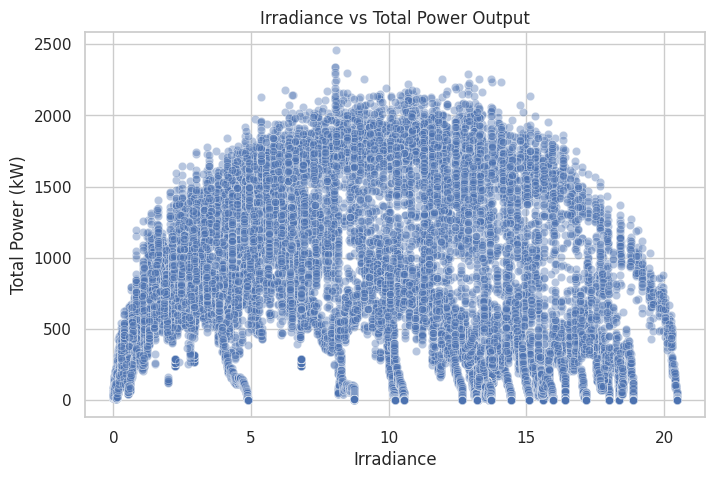

In [19]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="irradiance",
    y="total_power_kw",
    alpha=0.4
)
plt.title("Irradiance vs Total Power Output")
plt.xlabel("Irradiance")
plt.ylabel("Total Power (kW)")
plt.show()


### Interpretation

Power output generally increases with irradiance,
showing a strong positive relationship.
At higher irradiance levels, the output begins to plateau,
indicating physical or system efficiency limits.


### 15.2 Average Power Output per Cluster

This bar chart compares the average power output
across all solar clusters.


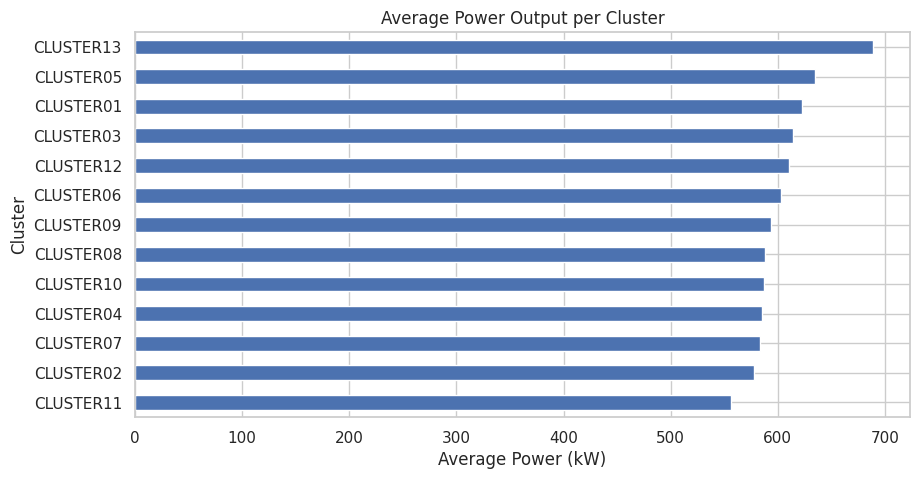

In [20]:
plt.figure(figsize=(10, 5))
avg_power_cluster = df.groupby("cluster")["total_power_kw"].mean().sort_values()

avg_power_cluster.plot(kind="barh")
plt.title("Average Power Output per Cluster")
plt.xlabel("Average Power (kW)")
plt.ylabel("Cluster")
plt.show()


### Interpretation

Some clusters consistently produce higher average power,
suggesting better efficiency or favorable positioning.
Lower-performing clusters may require further inspection
or maintenance.


### 15.3 Daily Total Power Generation

This line plot shows the total solar power generated per day
across all clusters during June 2024.
It helps identify daily trends and anomalies.


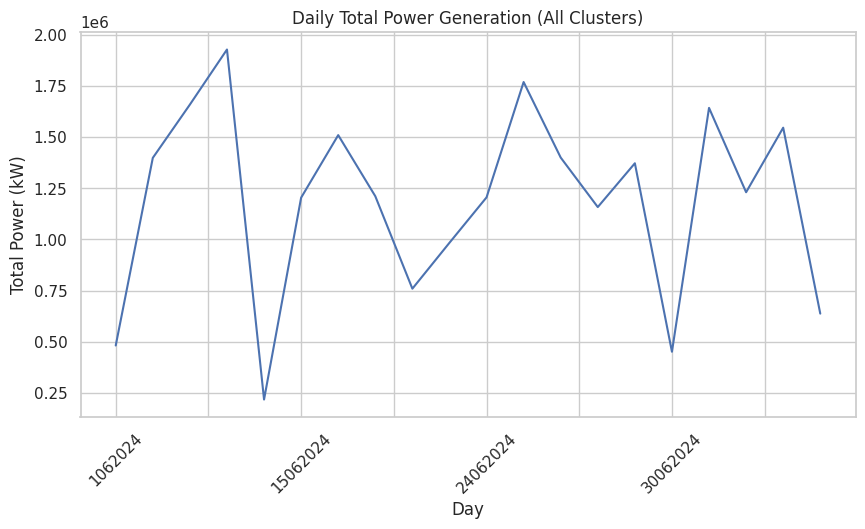

In [21]:
# Convert day to string for grouping
df["day_str"] = df["day"].astype(str)

# Calculate daily total power
daily_power = df.groupby("day_str")["total_power_kw"].sum()

plt.figure(figsize=(10, 5))
daily_power.plot()
plt.title("Daily Total Power Generation (All Clusters)")
plt.xlabel("Day")
plt.ylabel("Total Power (kW)")
plt.xticks(rotation=45)
plt.show()


### Interpretation

The daily power generation fluctuates across the month.
These variations may be caused by:
- Changes in weather conditions (cloud coverage, irradiance)
- Temporary system or inverter issues
- Maintenance or downtime on certain days


### 15.4 Distribution of Solar Irradiance

This histogram visualizes how solar irradiance values
are distributed throughout the dataset.


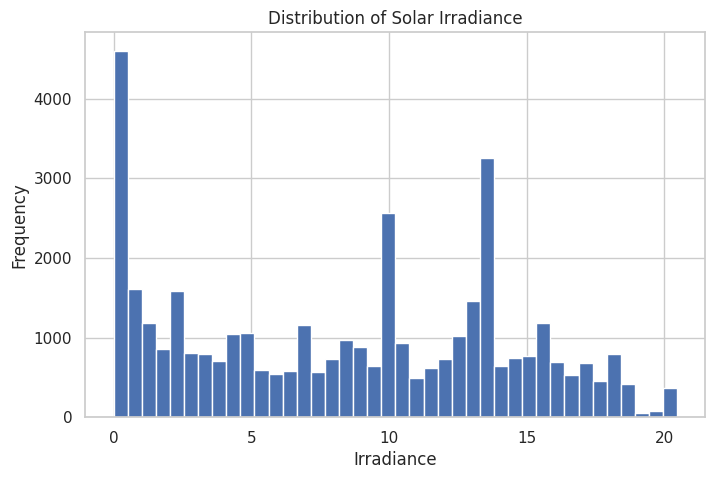

In [22]:
plt.figure(figsize=(8, 5))
plt.hist(df["irradiance"], bins=40)
plt.title("Distribution of Solar Irradiance")
plt.xlabel("Irradiance")
plt.ylabel("Frequency")
plt.show()


### Interpretation

Most irradiance values are concentrated at lower levels,
representing early morning, late afternoon, or cloudy periods.
Higher irradiance values correspond to peak sunlight hours.


### 15.5 Power Output Distribution per Cluster

This boxplot compares the distribution of power output
for each solar cluster.


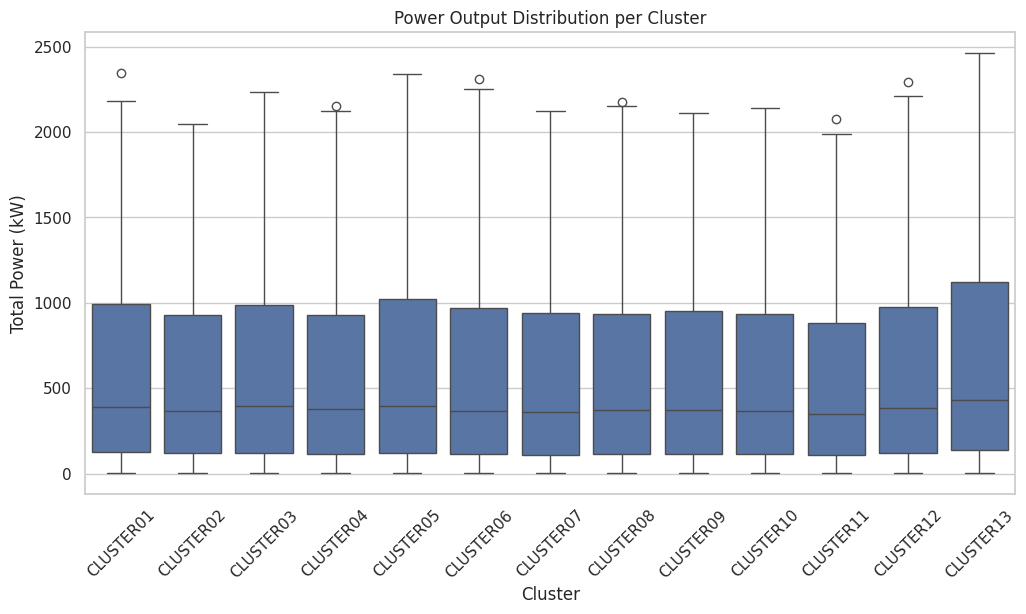

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="cluster",
    y="total_power_kw"
)
plt.title("Power Output Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Total Power (kW)")
plt.xticks(rotation=45)
plt.show()


### Interpretation

Most clusters show similar variability in power output,
while some clusters exhibit higher medians and wider ranges.
Outliers may indicate peak performance or unusual conditions.


### 15.6 Efficiency Comparison Across Clusters

Efficiency is defined as:
Efficiency = Total Power / Irradiance

This boxplot highlights how effectively each cluster
converts solar irradiance into usable power.


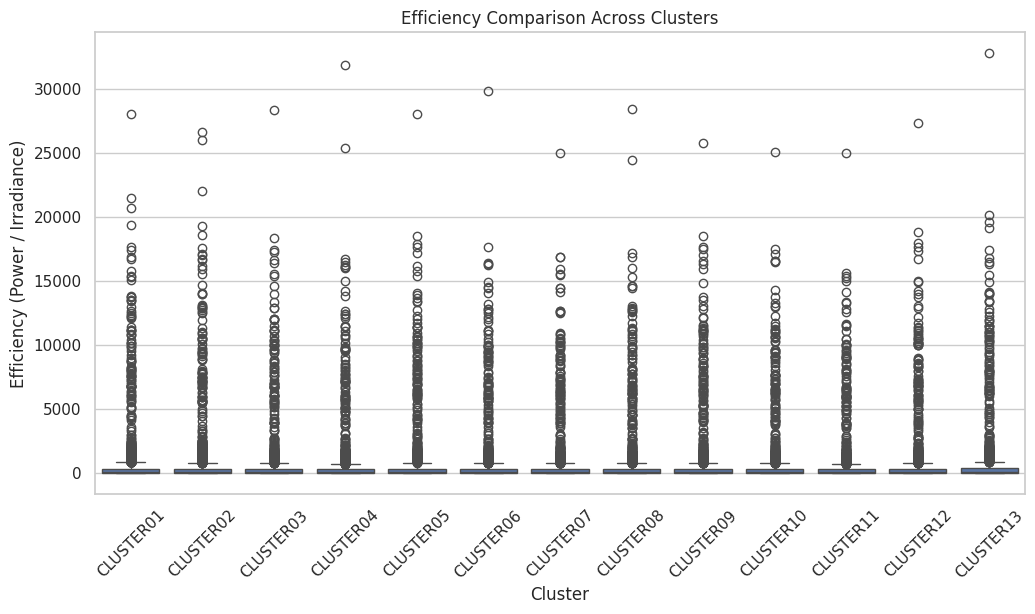

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="cluster",
    y="efficiency"
)
plt.title("Efficiency Comparison Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Efficiency (Power / Irradiance)")
plt.xticks(rotation=45)
plt.show()


### Interpretation

Clusters with higher median efficiency are more effective
in converting sunlight into energy.
Clusters with consistently lower efficiency may suffer from
hardware inefficiencies, shading, or misalignment.


### 15.7 Hourly Power Output Analysis

This analysis shows how power generation varies
throughout the day across all clusters.


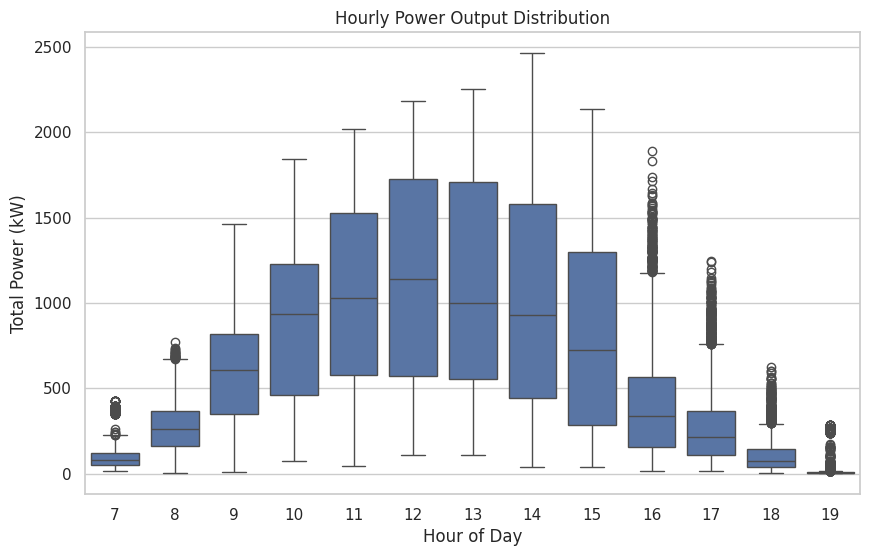

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="hour",
    y="total_power_kw"
)
plt.title("Hourly Power Output Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Total Power (kW)")
plt.show()


### Interpretation

Power generation typically peaks between late morning
and early afternoon, aligning with maximum solar irradiance.
Lower and more variable outputs are observed during
early morning and late evening hours.


## 16. Power Output Prediction (Regression Modeling)

The goal of this section is to predict the total power output (kW)
based on:
- Solar irradiance
- Time of day
- Solar cluster identity

This is formulated as a regression problem.


## 16.1 Feature Selection and Encoding

Categorical variables such as cluster labels must be encoded
before being used in machine learning models.


In [26]:
from sklearn.model_selection import train_test_split

# Select features and target
X = df[["irradiance", "hour", "cluster"]]
y = df["total_power_kw"]

# One-hot encode cluster feature
X_encoded = pd.get_dummies(X, columns=["cluster"], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 31491
Testing samples: 7873


## 16.2 Baseline Model: Linear Regression

Linear Regression is used as a baseline model
to evaluate whether simple linear relationships
are sufficient for this task.


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluation
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression MSE:", lr_mse)
print("Linear Regression R²:", lr_r2)


Linear Regression MSE: 288760.6444989319
Linear Regression R²: 0.06657435089786778


### Interpretation

Linear Regression performs poorly due to the
non-linear relationship between irradiance and power output.
This model is retained only as a baseline.


## 16.3 Random Forest Regressor

Random Forest is an ensemble model capable of capturing
non-linear patterns and feature interactions.


In [28]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest MSE:", rf_mse)
print("Random Forest R²:", rf_r2)


Random Forest MSE: 24080.22588495017
Random Forest R²: 0.9221600972799161


### Interpretation

Random Forest significantly outperforms Linear Regression,
achieving high R² and low prediction error.
This indicates strong non-linear relationships in the data.


## 16.4 XGBoost Regressor

XGBoost is a gradient boosting algorithm known
for high performance on structured data.


In [29]:
from xgboost import XGBRegressor

# Train XGBoost Regressor
xgb_reg = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

xgb_reg.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_reg.predict(X_test)

# Evaluation
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost MSE:", xgb_mse)
print("XGBoost R²:", xgb_r2)


XGBoost MSE: 58708.84013106511
XGBoost R²: 0.8102222783770818


## 16.5 Model Comparison (Regression)

We compare all regression models using MSE and R² metrics.


In [30]:
regression_results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "MSE": [lr_mse, rf_mse, xgb_mse],
    "R² Score": [lr_r2, rf_r2, xgb_r2]
})

regression_results


,Model,MSE,R² Score
0,Linear Regression,288760.644499,0.066574
1,Random Forest,24080.225885,0.922160
2,XGBoost,58708.840131,0.810222


### Conclusion (Regression)

Among all tested models:
- Linear Regression performs poorly
- XGBoost performs well
- Random Forest achieves the best performance

Therefore, Random Forest is selected
as the final regression model for power prediction.


## 16.6 Actual vs Predicted Power Output (Best Model)


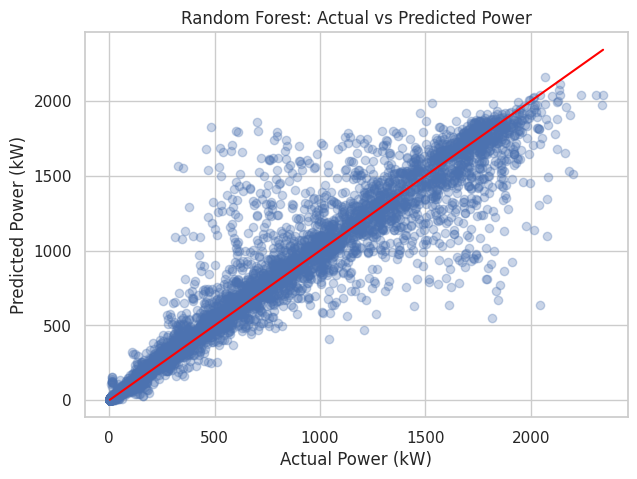

In [31]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel("Actual Power (kW)")
plt.ylabel("Predicted Power (kW)")
plt.title("Random Forest: Actual vs Predicted Power")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red")
plt.show()


### Interpretation

Predicted values closely follow actual values,
indicating strong predictive accuracy and model reliability.


## 16.7 Saving the Best Regression Model



In [32]:
import joblib

# Save Random Forest model
joblib.dump(rf_model, "random_forest_regressor.pkl")


['random_forest_regressor.pkl']

## 17. Cluster Performance Classification

In this section, we classify solar cluster performance into:
- High Performance
- Low Performance

The classification is based on an efficiency metric
derived from power output and solar irradiance.


## 17.1 Defining the Efficiency-Based Performance Label

Efficiency is calculated as:
Efficiency = Total Power / Irradiance

Clusters with efficiency above the median are labeled as:
- 1 → High Performance
- 0 → Low Performance


In [33]:
# Calculate efficiency
df["efficiency"] = df["total_power_kw"] / df["irradiance"]

# Define threshold using median efficiency
efficiency_threshold = df["efficiency"].median()

# Create binary performance label
df["performance_label"] = (df["efficiency"] >= efficiency_threshold).astype(int)

# Check label distribution
df["performance_label"].value_counts()


,count
performance_label,
1,19682
0,19682


## 17.2 Feature Selection for Classification

The classification model uses:
- Irradiance
- Hour of day
- Cluster identity (one-hot encoded)


In [34]:
# Select features and target
X_cls = df[["irradiance", "hour", "cluster"]]
y_cls = df["performance_label"]

# One-hot encode cluster
X_cls_encoded = pd.get_dummies(X_cls, columns=["cluster"], drop_first=True)

# Train-test split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls_encoded, y_cls, test_size=0.2, random_state=42
)

print("Training samples:", X_train_cls.shape[0])
print("Testing samples:", X_test_cls.shape[0])


Training samples: 31491
Testing samples: 7873


## 17.3 Baseline Classifier: Random Forest

A Random Forest classifier is trained as a baseline
before using a more advanced model.


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Train Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train_cls, y_train_cls)

# Predictions
y_pred_rf_cls = rf_clf.predict(X_test_cls)

# Confusion matrix
cm_rf = confusion_matrix(y_test_cls, y_pred_rf_cls)
cm_rf


array([[3630,  364],
       [ 275, 3604]])

### Baseline Classification Performance

The confusion matrix provides insight into how well
the model distinguishes between high and low performance clusters.


## 17.4 Advanced Classifier: XGBoost


In [36]:
from xgboost import XGBClassifier

# Train XGBoost Classifier
xgb_clf = XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_clf.fit(X_train_cls, y_train_cls)

# Predictions
y_pred_xgb_cls = xgb_clf.predict(X_test_cls)
y_prob_xgb_cls = xgb_clf.predict_proba(X_test_cls)[:, 1]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:40:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 17.5 Confusion Matrix (XGBoost Classifier)



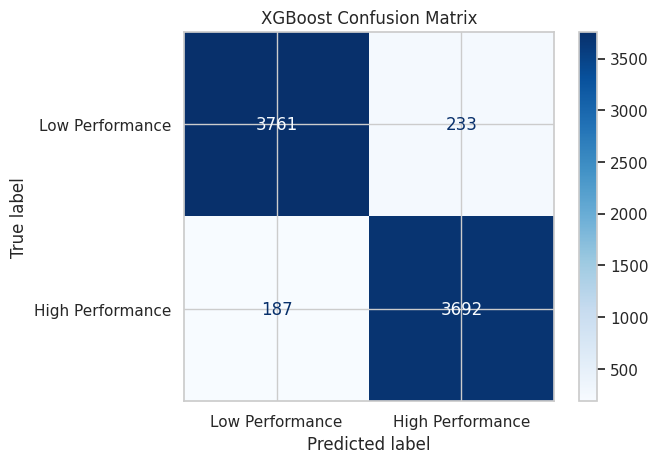

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_xgb = confusion_matrix(y_test_cls, y_pred_xgb_cls)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_xgb,
    display_labels=["Low Performance", "High Performance"]
)

disp.plot(cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()



### Interpretation

The confusion matrix shows strong classification performance,
with most clusters correctly labeled as high or low performance.


## 17.6 ROC Curve and AUC Score


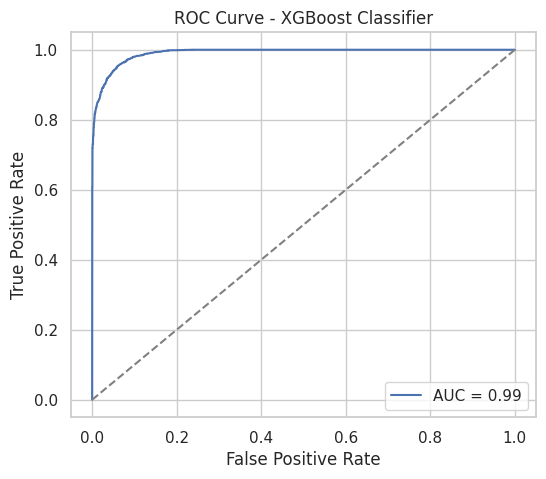

AUC Score: 0.9909688908201177


In [38]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test_cls, y_prob_xgb_cls)
auc_score = roc_auc_score(y_test_cls, y_prob_xgb_cls)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost Classifier")
plt.legend()
plt.show()

print("AUC Score:", auc_score)


### Interpretation

An AUC score close to 1.0 indicates excellent ability
to distinguish between high and low performing clusters.


## 17.7 Saving the Best Classification Model


In [39]:
# Save XGBoost classifier
joblib.dump(xgb_clf, "xgb_cluster_performance_classifier.pkl")


['xgb_cluster_performance_classifier.pkl']

## 18. Final Summary and Conclusions

This notebook demonstrated:
- End-to-end data preprocessing and feature engineering
- Exploratory data analysis for solar performance insights
- Regression modeling for power output prediction
- Classification modeling for cluster performance evaluation

The developed models provide valuable decision support
for monitoring and optimizing solar power systems.
